In [1]:
!pwd

/global/cscratch1/sd/shl159/projects/fake_injection_summer_2022/dia_improvement/devel


In [2]:
import os
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lsst.daf.persistence import Butler
import fakeInjectionPipeline as fip
import data_process_utils as dpu
from scipy.stats import norm
import scipy.stats as stats
import lsst.geom as geom
from scipy.stats import sigmaclip

In [3]:
conn = sqlite3.connect('./data/table/gal_4639/injection_coord.sqlite')
calexp_info_query = (f'SELECT distinct(visit), filter, detector, patch_1, patch_2, tract FROM injection_coord')
calexp_info = pd.read_sql_query(calexp_info_query, conn)

In [4]:
COADD_REPO = ('/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy')
CALEXP_REPO = ('/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1')

coadd_butler = Butler(COADD_REPO)
calexp_butler = Butler(CALEXP_REPO)

In [5]:
flux_db_patch = (
        f'./data'
        f'/patch_0to6/diff/al_default/detection/detection.sqlite'
)
conn = sqlite3.connect(flux_db_patch)

full_query = 'SELECT * FROM fake_src'
fake_src_full = pd.read_sql_query(full_query, conn)

In [6]:
def cal_eff(fake_src, threshold):
    detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
    detected_fake = detected_fake.loc[
        np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > threshold
    ].copy().reset_index(drop=True)
    eff = len(detected_fake) / len(fake_src)
    err = np.sqrt(eff / len(fake_src))
    n_of_fake = len(fake_src)
    return eff, err, n_of_fake  

In [7]:
def get_efficiency(fake_src_df, fake_mag_list=None, threshold=5):    
    efficiency_list = []
    err_list = []
    n_of_fake_list = []
    for fake_mag in fake_mag_list:
        fake_mag_str = str(fake_mag).replace('.', '')
        fake_num, detected_fake = 0, 0
        fake_src = fake_src_df.loc[fake_src_df.fake_mag == fake_mag_str].copy().reset_index(drop=True)
        eff, err, n_of_fake = cal_eff(fake_src, threshold)
        efficiency_list.append(eff)
        err_list.append(err)
        n_of_fake_list.append(n_of_fake)
    return efficiency_list, err_list, n_of_fake_list

In [8]:
fake_mag_list = [20, 21, 22, 23, 24]
eff_list, err_list, n_of_fake_list = get_efficiency(fake_src_full, fake_mag_list=fake_mag_list, threshold=5.5)

In [9]:
fake_mag = 20
threshold = 5.5
fake_mag_str = str(fake_mag).replace('.', '')
fake_src_df = fake_src_full
fake_src = fake_src_df.loc[fake_src_df.fake_mag == fake_mag_str]

detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]

detected_fake = detected_fake.loc[
    np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > threshold
]


df = (detected_fake.base_PsfFlux_instFlux - detected_fake.injected_instFlux) / detected_fake.base_PsfFlux_instFluxErr
clipped, _, _ = stats.sigmaclip(df.to_numpy())

norm_x = np.arange(-5, 5, 0.1)
norm_y = norm.pdf(norm_x)
norm_cdf = stats.norm(loc=0, scale=1).cdf
threshold = 5


In [10]:
def get_efficiency(fake_src_df, host_mag_list=None, fake_mag_list=None, threshold=5):
    eff_dict, err_dict, n_of_fake_dict = {}, {}, {}
    for host_mag in host_mag_list:
        efficiency_list = []
        err_list = []
        n_of_fake_list = []
        for fake_mag in fake_mag_list:
            fake_mag_str = str(fake_mag).replace('.', '')
            fake_num, detected_fake = 0, 0
            fake_src = fake_src_df.loc[
                np.logical_and(
                    fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
            )].copy().reset_index(drop=True)
            eff, err, n_of_fake = cal_eff(fake_src, threshold)
            efficiency_list.append(eff)
            err_list.append(err)
            n_of_fake_list.append(n_of_fake)
        eff_dict[host_mag] = efficiency_list
        err_dict[host_mag] = err_list
        n_of_fake_dict[host_mag] = n_of_fake_list
    return eff_dict, err_dict, n_of_fake_dict

In [11]:
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]
host_mag_range_list = [(20, 21), (21, 22), (22, 23), (23, 24), (24, 25)]
color_list=['r', 'orange', 'y', 'g', 'blue']

threshold = 5.5
eff_dict = {}
n_of_fake_dict = {}

for host_idx, host_mag in enumerate(host_mag_list):
    color = color_list[host_idx]    
    efficiency_list = []
    n_of_fake_list = []
    af_list = []
    for fake_mag in fake_mag_list:
        fake_mag_str = str(fake_mag).replace('.', '')
        
        fake_num = 0
        detected_fake = 0
        
        fake_src = fake_src_df.loc[
            np.logical_and(
                fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
        )]

        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        
        detected_fake = detected_fake.loc[
            np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > threshold
        ]

        eff = len(detected_fake) / len(fake_src)
        
        efficiency_list.append(eff)
        n_of_fake_list.append(len(detected_fake))
        
    eff_dict[host_mag] = efficiency_list
    n_of_fake_dict[host_mag] = n_of_fake_list

In [12]:
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]
eff_dict, err_dict, n_of_fake_dict = get_efficiency(
    fake_src_full, host_mag_list=host_mag_list, fake_mag_list=fake_mag_list, threshold=5
)

In [13]:
from scipy.optimize import curve_fit

In [14]:
def get_efficiency(fake_src_df, host_mag_list=None, fake_mag_list=None, threshold=5):
    eff_dict, err_dict, n_of_fake_dict = {}, {}, {}
    for host_mag in host_mag_list:
        efficiency_list = []
        err_list = []
        n_of_fake_list = []
        for fake_mag in fake_mag_list:
            fake_mag_str = str(fake_mag).replace('.', '')
            fake_num, detected_fake = 0, 0
            fake_src = fake_src_df.loc[
                np.logical_and(
                    fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
            )].copy().reset_index(drop=True)
            eff, err, n_of_fake = cal_eff(fake_src, threshold)
            efficiency_list.append(eff)
            err_list.append(err)
            n_of_fake_list.append(n_of_fake)
        eff_dict[host_mag] = efficiency_list
        err_dict[host_mag] = err_list
        n_of_fake_dict[host_mag] = n_of_fake_list
    return eff_dict, err_dict, n_of_fake_dict

Text(0, 0.5, 'density')

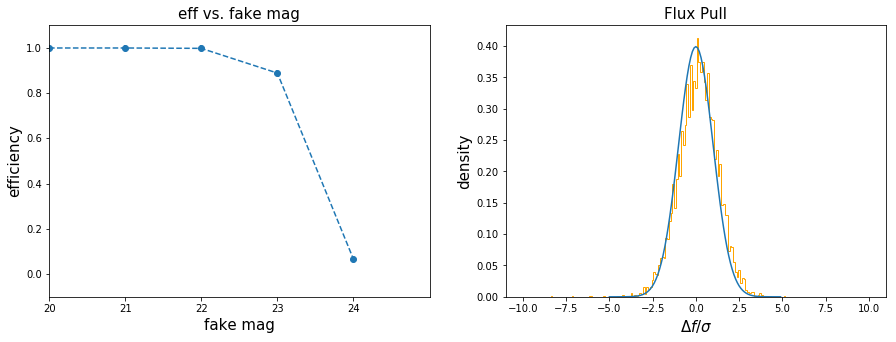

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bins = np.linspace(-10, 10, 200)

ax[0].errorbar(fake_mag_list, eff_list, yerr=err_list,marker='o', ls='--')
ax[0].set_xticks(fake_mag_list)
ax[0].set_xticklabels(fake_mag_list)
ax[0].set_xlim(20, 25)
ax[0].set_ylim((-0.1, 1.1))
ax[0].set_xlabel('fake mag', size=15)
ax[0].set_ylabel('efficiency', size=15)
ax[0].set_title('eff vs. fake mag', size=15)

ax[1].hist(df ,density=True, bins=bins,color='orange', histtype='step')
ax[1].plot(norm_x, norm_y)
ax[1].set_title(f'Flux Pull', size=15)
ax[1].set_xlabel('$\Delta f / \sigma$', size=15)
ax[1].set_ylabel('density', size=15)

In [16]:
def sigmoid(x, a, b):
    y = 1 / (1 + np.exp( - a * (x - b) ) )
    return y

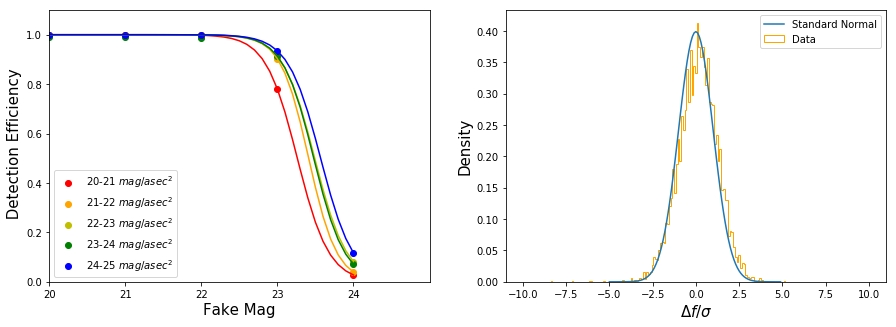

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bins = np.linspace(-10, 10, 200)
x_ls = np.arange(20, 24.09, 0.1)
for host_idx, host_mag in enumerate(host_mag_list):
    mag = host_mag.split('_')
    color = color_list[host_idx]
    n_of_fake = n_of_fake_dict[host_mag]
    popt, pcov = curve_fit(sigmoid, fake_mag_list, eff_dict[host_mag], bounds=((-20, 0),(0, 50)))
    y_ls = []
    for x in x_ls:
        y = sigmoid(x, popt[0], popt[1])
        y_ls.append(y)
    ax[0].plot(x_ls, y_ls, color=color)
    # ax[0].errorbar(fake_mag_list, eff_dict[host_mag], yerr=err_dict[host_mag], marker='o', ls='--', color=color, label=f'{mag[0]}-{mag[1]} $mag / asec^2$')
    ax[0].scatter(fake_mag_list, eff_dict[host_mag],
               marker='o', color=color, label=f'{mag[0]}-{mag[1]} $mag / asec^2$')
ax[0].set_xticks(fake_mag_list)
ax[0].set_xticklabels(fake_mag_list)
ax[0].set_xlim(20, 25)
ax[0].set_ylim((0., 1.1))
ax[0].set_xlabel('Fake Mag', size=15)
ax[0].set_ylabel(' Detection Efficiency', size=15)
#ax[0].set_title('eff vs. fake mag', size=15)
ax[0].legend()

ax[1].hist(df ,density=True, bins=bins,color='orange', histtype='step', label='Data')
ax[1].plot(norm_x, norm_y, label='Standard Normal')
# ax[1].set_title(f'Flux Pull', size=15)
ax[1].set_xlabel('$\Delta f / \sigma$', size=15)
ax[1].set_ylabel('Density', size=15)
ax[1].legend()
plt.savefig('5_eff_flux.png', dpi=1000)

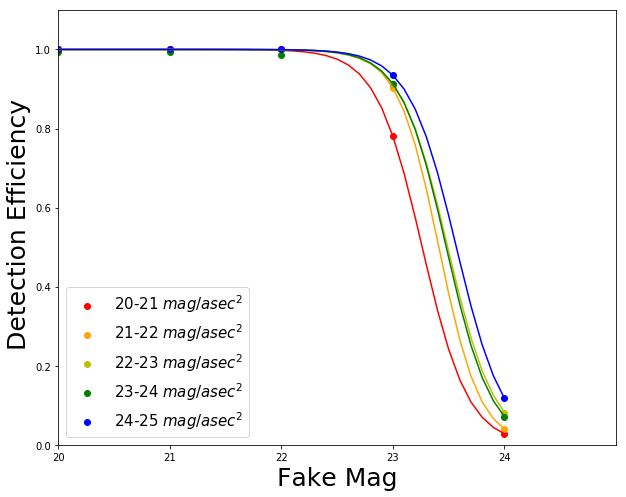

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
x_ls = np.arange(20, 24.09, 0.1)
for host_idx, host_mag in enumerate(host_mag_list):
    mag = host_mag.split('_')
    color = color_list[host_idx]
    n_of_fake = n_of_fake_dict[host_mag]
    popt, pcov = curve_fit(sigmoid, fake_mag_list, eff_dict[host_mag], bounds=((-20, 0),(0, 50)))
    y_ls = []
    for x in x_ls:
        y = sigmoid(x, popt[0], popt[1])
        y_ls.append(y)
    ax.plot(x_ls, y_ls, color=color)
    # ax[0].errorbar(fake_mag_list, eff_dict[host_mag], yerr=err_dict[host_mag], marker='o', ls='--', color=color, label=f'{mag[0]}-{mag[1]} $mag / asec^2$')
    ax.scatter(fake_mag_list, eff_dict[host_mag],
               marker='o', color=color, label=f'{mag[0]}-{mag[1]} $mag / asec^2$')
ax.set_xticks(fake_mag_list)
ax.set_xticklabels(fake_mag_list)
ax.set_xlim(20, 25)
ax.set_ylim((0., 1.1))
ax.set_xlabel('Fake Mag', size=25)
ax.set_ylabel(' Detection Efficiency', size=25)
#ax[0].set_title('eff vs. fake mag', size=15)
ax.legend(fontsize=15)
plt.savefig('eff.pdf', dpi=100)

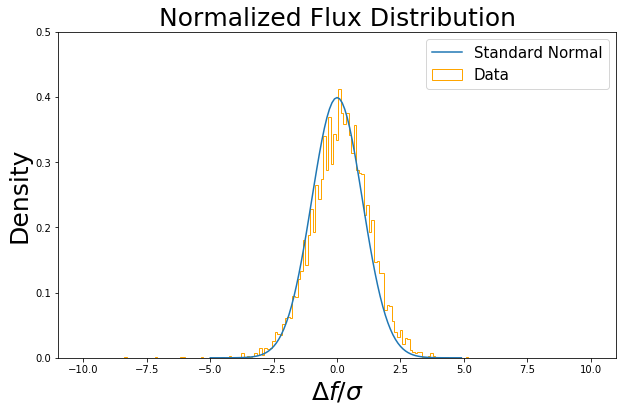

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bins = np.linspace(-10, 10, 200)
ax.hist(df ,density=True, bins=bins,color='orange', histtype='step', label='Data')
ax.plot(norm_x, norm_y, label='Standard Normal')
# ax[1].set_title(f'Flux Pull', size=15)
ax.set_ylim((0, 0.5))
ax.set_xlabel('$\Delta f / \sigma$', size=25)
ax.set_ylabel('Density', size=25)
ax.set_title('Normalized Flux Distribution', size=25)
ax.legend(fontsize=15)
plt.savefig('eff.pdf', dpi=100)

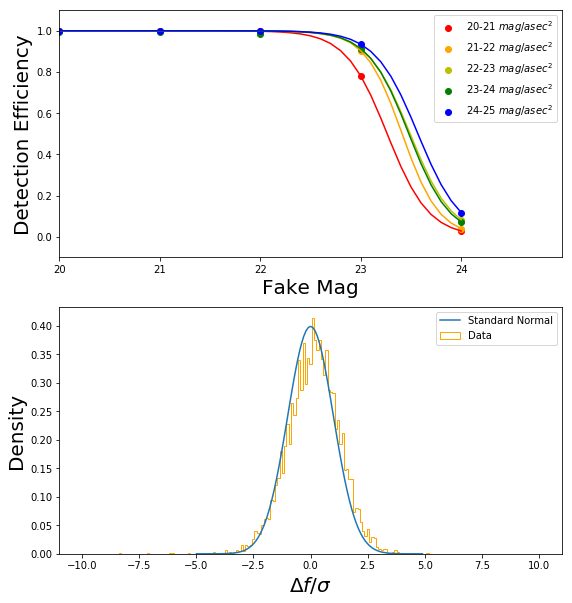

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(9, 10))
bins = np.linspace(-10, 10, 200)
x_ls = np.arange(20, 24.09, 0.1)
for host_idx, host_mag in enumerate(host_mag_list):
    mag = host_mag.split('_')
    color = color_list[host_idx]
    n_of_fake = n_of_fake_dict[host_mag]
    popt, pcov = curve_fit(sigmoid, fake_mag_list, eff_dict[host_mag], bounds=((-20, 0),(0, 50)))
    y_ls = []
    for x in x_ls:
        y = sigmoid(x, popt[0], popt[1])
        y_ls.append(y)
    ax[0].plot(x_ls, y_ls, color=color)
    #ax[0].errorbar(fake_mag_list, eff_dict[host_mag], yerr=err_dict[host_mag],
    # marker='o', ls='--', color=color, label=f'{mag[0]}-{mag[1]} $mag / asec^2$')
    ax[0].scatter(fake_mag_list, eff_dict[host_mag],
                marker='o', color=color, label=f'{mag[0]}-{mag[1]} $mag / asec^2$')

ax[0].set_xticks(fake_mag_list)
ax[0].set_xticklabels(fake_mag_list)
ax[0].set_xlim(20, 25)
ax[0].set_ylim((-0.1, 1.1))
ax[0].set_xlabel('Fake Mag', size=20)
ax[0].set_ylabel('Detection Efficiency', size=20)
#ax[0].set_title('eff vs. fake mag', size=15)
ax[0].legend()

ax[1].hist(df ,density=True, bins=bins,color='orange', histtype='step', label='Data')
ax[1].plot(norm_x, norm_y, label='Standard Normal')
# ax[1].set_title(f'Flux Pull', size=15)
ax[1].set_xlabel('$\Delta f / \sigma$', size=20)
ax[1].set_ylabel('Density', size=20)
ax[1].legend()
plt.savefig('5_eff_flux_vertical.png', dpi=1000)

In [33]:
x_ls = np.arange(20, 24.09, 0.1)



In [113]:
def sigmoid(x, a, b, c):
    y = 1 / (1 + np.exp(-a * x + b) ) + c
    return y